In [1]:
import numpy as np
import pandas as pd
import pypianoroll as pr
import matplotlib.pyplot as plt
import importlib
import json
import xml.etree.ElementTree as ET
import os
import sys
import pickle

In [2]:
sys.path.append('..')
import dataloader
importlib.reload(dataloader)
from dataloader import DataLoader
importlib.reload(DataLoader)
DL = DataLoader.DataLoader(device='cuda')
# DL.process_raw_data()

reading train_data
reading chord_dic
reading compressed_data


#### 统计出现了多少种和弦

(array([ 1.,  1.,  1.,  2.,  0.,  3.,  0.,  1.,  0.,  2.,  3.,  0.,  0.,
         2.,  4.,  2.,  2.,  2.,  3.,  6.,  3.,  8.,  4.,  9., 12.,  4.,
         8.,  8., 10., 13., 17., 10., 15., 18., 20., 18., 24., 20., 15.,
        14., 22., 28., 22., 28., 33., 23., 27., 31., 24., 27., 29., 22.,
        24., 22., 23., 23., 16., 25., 25., 24., 30., 13., 17., 10., 16.,
        17., 16.,  8.,  6.,  6.,  9.,  6., 14.,  5.,  1.,  5.,  2.,  4.,
         2.,  4.,  6.,  3.,  4.,  0.,  1.,  2.,  0.,  1.,  2.,  0.,  1.,
         0.,  0.,  0.,  3.,  1.,  1.,  0.,  0.,  1.]),
 array([-3.1780455e+00, -3.1117754e+00, -3.0455053e+00, -2.9792352e+00,
        -2.9129651e+00, -2.8466949e+00, -2.7804248e+00, -2.7141550e+00,
        -2.6478848e+00, -2.5816147e+00, -2.5153446e+00, -2.4490745e+00,
        -2.3828044e+00, -2.3165343e+00, -2.2502642e+00, -2.1839941e+00,
        -2.1177239e+00, -2.0514538e+00, -1.9851838e+00, -1.9189137e+00,
        -1.8526436e+00, -1.7863735e+00, -1.7201035e+00, -1.6538334e+00,
  

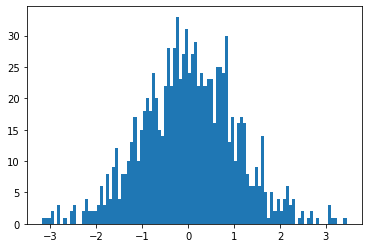

In [36]:
import torch
plt.hist(torch.randn(1000).numpy(),bins=100)